## Import

In [1]:
import random
import pandas as pd
import numpy as np
import os
import re
import glob
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from tqdm.auto import tqdm


from timm.loss import AsymmetricLossSingleLabel
from timm.data.mixup import Mixup
from timm.data.auto_augment import RandAugment, rand_augment_transform
from timm.data.random_erasing import RandomErasing
from cosine_annealing_warmup import CosineAnnealingWarmupRestarts

import warnings
warnings.filterwarnings(action='ignore') 

/opt/conda/envs/paper/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Hyperparameter Setting

In [3]:
CFG = {
    'IMG_SIZE':384,
    'EPOCHS':40,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':16,
    'SEED':41
}

## Fixed RandomSeed

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Data Pre-processing

In [5]:
all_img_list = glob.glob('../data/train/*/*')

In [6]:
df = pd.DataFrame(columns=['img_path', 'label'])
df['img_path'] = all_img_list
df['label'] = df['img_path'].apply(lambda x : str(x).split('/')[-2])

In [7]:
train, val, _, _ = train_test_split(df, df['label'], test_size=0.3, stratify=df['label'], random_state=CFG['SEED'])

## Label-Encoding

In [8]:
le = preprocessing.LabelEncoder()
train['label'] = le.fit_transform(train['label'])
val['label'] = le.transform(val['label'])

In [9]:
val['label'].value_counts()

18    422
10    179
1      92
3      63
15     49
2      44
11     43
7      39
6      30
9      17
5      16
17     15
14      9
12      8
13      5
4       4
16      1
0       1
8       1
Name: label, dtype: int64

## CustomDataset

In [10]:
mixup_args = {
    'mixup_alpha': 0.8,
    'cutmix_alpha': 1,
    'cutmix_minmax': None,
    'prob': 1.0,
    'switch_prob': 0.5,
    'mode': 'elem',
    'label_smoothing': 0.1,
    'num_classes': 19}

# rand_augment_transform(config_str='rand-m9-mstd0.5')


train_transform_4_origin = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

train_transform_1 = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.OpticalDistortion(distort_limit=(-0.3, 0.3), shift_limit=0.5, p=0.5),
                            A.HorizontalFlip(),
                            A.Affine(scale=(0.9, 2), translate_percent=(-0.1, 0.1), rotate=(-10, 10), shear=(-20,20)),
                            A.ElasticTransform(alpha=300),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

train_transform_2 = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.AdvancedBlur(),
                            A.HorizontalFlip(),
                            A.ColorJitter(),
                            A.GaussNoise(),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

train_transform_3 = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.AdvancedBlur(),
                            A.ColorJitter(),
                            A.GaussNoise(),
                            A.OpticalDistortion(distort_limit=(-0.3, 0.3), shift_limit=0.5, p=0.5),
                            A.HorizontalFlip(),
                            A.Affine(scale=(0.9, 2), translate_percent=(-0.1, 0.1), rotate=(-10, 10), shear=(-20,20)),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            A.ElasticTransform(alpha=300),
                            ToTensorV2()
                            ])


test_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

In [11]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, transforms=None):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.transforms = transforms
        
    def __getitem__(self, index):
        img_path = self.img_path_list[index]
        
        image = cv2.imread(img_path)
        image1 = train_transform_1(image=image)['image']
        image2 = train_transform_2(image=image)['image']
        image3 = train_transform_3(image=image)['image']

        # print(image1)
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image']

        if self.label_list is not None:
            label = self.label_list[index]
            # print(label)
            image = torch.stack((image,image1,image2,image3))
            return image, label.repeat(4, 0)
        else:
            return image
        
    def __len__(self):
        return len(self.img_path_list)

In [12]:
train_dataset = CustomDataset(train['img_path'].values, train['label'].values, train_transform_4_origin)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

val_dataset = CustomDataset(val['img_path'].values, val['label'].values, test_transform)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

## Model Define

In [13]:
class BaseModel(nn.Module):
    def __init__(self, num_classes=len(le.classes_)):
        super(BaseModel, self).__init__()
        
        self.backbone = models.convnext_tiny(pretrained=True)
        self.norm = nn.LayerNorm(1000)
        self.act = nn.SiLU()
        self.drop = nn.Dropout1d()
        self.classifier = nn.Linear(1000, num_classes)
        
    def forward(self, x):
        x = self.backbone(x)
        x = self.norm(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.classifier(x)
        return x

In [14]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduce = reduce

    def forward(self, inputs, targets):
    
        ce_loss = nn.CrossEntropyLoss()(inputs, targets)

        pt = torch.exp(-ce_loss)  # CE(pt) = -log(pt) --> -ce_loss = log(pt) --> exp(log(pt)) --> pt
        F_loss = self.alpha * (1-pt)**self.gamma * ce_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

## Train

In [15]:
def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss = []
    preds, true_labels = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(iter(val_loader)):
            imgs, _, _, _ = torch.chunk(imgs,chunks=4, dim=1)
            # print(imgs.shape)
            # print(imgs.squeeze(1).shape)
            imgs = imgs.squeeze(1)
            imgs = imgs.float().to(device)
            labels = labels[:,0].to(device)
            
            pred = model(imgs)
            # print(labels.shape)
            
            loss = criterion(pred, labels)
            
            preds += pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += labels.detach().cpu().numpy().tolist()
            
            val_loss.append(loss.item())
        
        _val_loss = np.mean(val_loss)
        _val_score = f1_score(true_labels, preds, average='weighted')
    
    return _val_loss, _val_score

def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = FocalLoss().to(device)
    mixup_fn = Mixup(**mixup_args)
    rand_erase = RandomErasing(probability=0.25, mode='pixel', device='cpu')
    
    best_score = 0
    best_model = None
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for imgs, labels in tqdm(iter(train_loader)):
            imgs = torch.concat(torch.chunk(imgs,chunks=4, dim=1), dim=0).squeeze()

            imgs = rand_erase(imgs)
            if (imgs.shape[0] % 2 == 0):
                imgs, labels = mixup_fn(imgs, labels)
            imgs = imgs.float().to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            output = model(imgs)
            # print(output.shape, labels.shape)
            # print(labels)
            loss = criterion(output, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
            
            if scheduler is not None:
                scheduler.step()
                print(scheduler.get_lr())
                    
        _val_loss, _val_score = validation(model, criterion, val_loader, device)
        _train_loss = np.mean(train_loss)
        print('f{epoch} epoch done')
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val Weighted F1 Score : [{_val_score:.5f}]')

        # if scheduler is not None:
        #     scheduler.step()
        #     print(scheduler.get_lr())
            
        if best_score < _val_score:
            best_score = _val_score
            best_model = model
    
    return best_model

## Run!!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 3, 384, 384])
label [11 11 11 11]


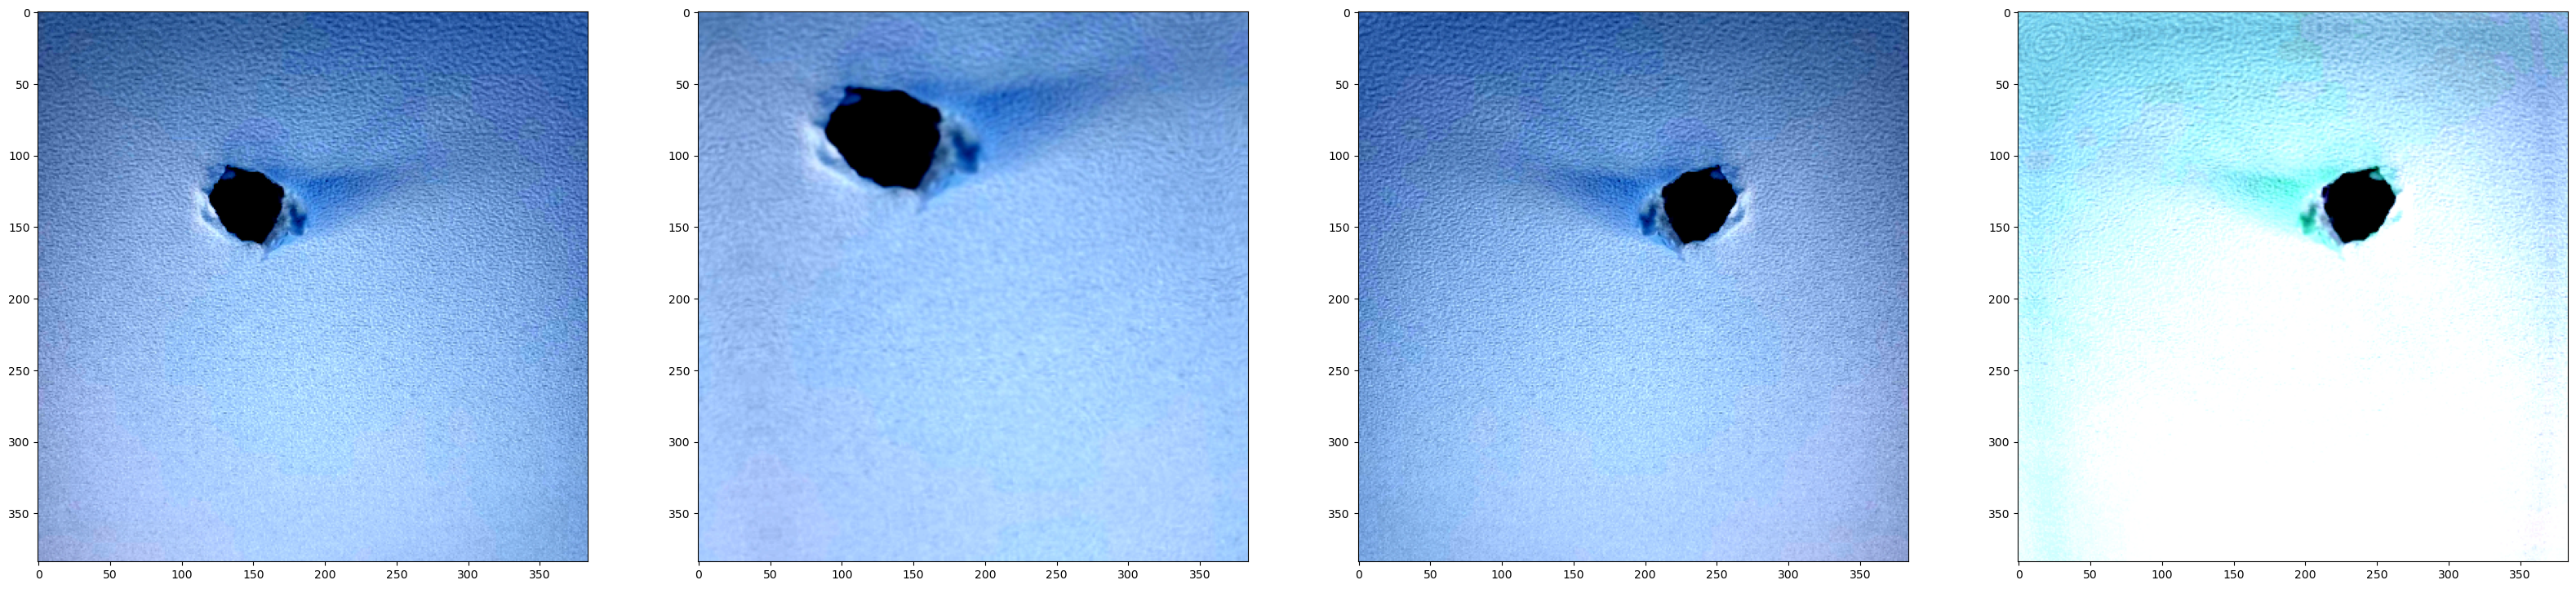

In [16]:
import matplotlib.pyplot as plt

f, axarr = plt.subplots(1,4)
f.set_figheight(20)
f.set_figwidth(40)

item_idx = 8

x , y = train_dataset[item_idx]
print(x.shape)
# print(train_dataset[0][0][1].permute(1,2,0))

axarr[0].imshow(x[0].permute(1,2,0))
axarr[1].imshow(x[1].permute(1,2,0))
axarr[2].imshow(x[2].permute(1,2,0))
axarr[3].imshow(x[3].permute(1,2,0))

print(f'label {y}')


In [ ]:
model = BaseModel()
model.eval()
optimizer = torch.optim.AdamW(params = model.parameters(), lr = CFG["LEARNING_RATE"], eps=1e-8, betas=[0.9, 0.999], weight_decay=0.05)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-8, verbose=True)
scheduler = CosineAnnealingWarmupRestarts(optimizer=optimizer, first_cycle_steps=CFG["EPOCHS"], cycle_mult=1, max_lr=CFG["LEARNING_RATE"], min_lr=0.001*CFG["LEARNING_RATE"], warmup_steps=5, gamma=0.9)

infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)



## Inference

In [ ]:
test = pd.read_csv('/root/Competitions/DACON/Papering_clf/data/test.csv')

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, transforms=None):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.transforms = transforms
        
    def __getitem__(self, index):
        img_path = f'/root/Competitions/DACON/Papering_clf/data/test/{self.img_path_list[index].split("/")[-1]}'
        
        image = cv2.imread(img_path)
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image']
        
        if self.label_list is not None:
            label = self.label_list[index]
            return image, label
        else:
            return image
        
    def __len__(self):
        return len(self.img_path_list)

In [ ]:
test_dataset = CustomDataset(test['img_path'].values, None, test_transform)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [ ]:
def inference(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for imgs in tqdm(iter(test_loader)):
            imgs = imgs.float().to(device)
            
            pred = model(imgs)
            
            preds += pred.argmax(1).detach().cpu().numpy().tolist()
    
    preds = le.inverse_transform(preds)
    return preds

In [ ]:
preds = inference(infer_model, test_loader, device)

100%|██████████| 13/13 [00:13<00:00,  1.06s/it]


## Submission

In [ ]:
submit = pd.read_csv('/root/Competitions/DACON/Papering_clf/data/sample_submission.csv')

In [ ]:
submit['label'] = preds

In [ ]:
submit.to_csv('/root/Competitions/DACON/Papering_clf/prediction/DeiT setup (ConvNeXt, BA4).csv', index=False)